In [7]:
import torch
torch.set_default_dtype(torch.float64)
from gutzwiller import Gutzwiller
from utils.make_kpoints import kmesh_sampling
import torch_optimizer as optim
import torch.optim as toptim

kpoints = torch.tensor(kmesh_sampling([5,5,5], False)) * 2 * torch.pi
# print(kpoints)

t = torch.cos(kpoints).mean(-1)

# l = torch.eye(2)
# l[1,1] = -1
l = torch.zeros(2,2)
U = 3.0
J = 0.01 * U
Up = U - 2*J
Jp = J
l = torch.zeros(2,2)
gz = Gutzwiller(
    norb=2,
    t=-(t.reshape(-1,1,1) * torch.eye(4)).reshape(kpoints.shape[0],2,2,2,2),
    U=U,
    Up=Up,
    J=J,
    Jp=Jp,
    l=l,
    R=torch.tensor([[0,0,0]]), 
    kpoints=kpoints,
    kspace=True, 
    Nocc=2,
)


In [8]:
opt = optim.Yogi(gz.parameters(), lr=0.15)
lr_schedular = torch.optim.lr_scheduler.StepLR(opt, step_size=500, gamma=0.8)
old_density = gz.get_density().reshape(4,4).diag()

for i in range(15000):
    opt.zero_grad()
    if i < 500:
        loss = gz(False)
    else:
        loss = gz(True)
    loss.backward()
    opt.step()
    lr_schedular.step()

    new_density = gz.get_density().reshape(4,4).diag()
    
    if i % 1000 == 0:
        new_density = gz.get_density().reshape(4,4).diag()
        print("Iter ", i, "\tloss", loss.item(), "\tlr:", opt.param_groups[0]['lr'], r"\delta: ", (new_density-old_density).abs().max().item())
        old_density = new_density
        gz.analysis()


Iter  0 	loss 6.380100464723714 	lr: 0.15 \delta:  0.05877866725054348
penalty_density:  0.11510627308545827 penalty_diag_density:  0.3658734578565299 T+U 2.787465028254902 T:  -0.034168937819192974 U:  2.8216339660740952 N:  2.0 efermi:  0.0014661940844501674 



Iter  1000 	loss 2.9380224993651693 	lr: 0.096 \delta:  0.1306249924990892
penalty_density:  8.147016666350975e-05 penalty_diag_density:  0.00010823375677215807 T+U 2.936853871262626 T:  -0.13139625562639484 U:  3.068250126889021 N:  2.0 efermi:  0.01230576462098035 

Iter  2000 	loss 2.9643455597911443 	lr: 0.06144000000000001 \delta:  0.07715366069853596
degenerated states: 10, required states: 5
penalty_density:  0.003753991673834645 penalty_diag_density:  0.00034794683602301646 T+U 2.925310809435298 T:  -0.19935332663635297 U:  3.124664136071651 N:  2.0 efermi:  0.01913184917070436 

Iter  3000 	loss 2.947496235354307 	lr: 0.03932160000000001 \delta:  0.01843250978828692
degenerated states: 8, required states: 5
penalty_density:  0.001846752248523689 penalty_diag_density:  9.761712576406012e-05 T+U 2.9217090972320157 T:  -0.21081698888562028 U:  3.132526086117636 N:  2.0 efermi:  0.020308973360829444 

Iter  4000 	loss 2.9478973860522886 	lr: 0.02516582400000001 \delta:  0.00959082

In [6]:
gz.get_R().reshape(4,4).diag()

tensor([-0.5801, -0.5804, -0.5799, -0.5778])

1. Is this first $\hat{T}$ and then $\hat{T}+\hat{U}$ method general? Would it bias the solutions? maybe cause some solution unavailable.
2. How to improve the numerical accuracy?
3. How to incoperate randomness for nonconvex stochastical optimization? What is the batch?
4. More regulariation on the parameters? Using the continuity in k space? 
5. More parameter for $c$? Which means more basis? Is there systematic way to do overparameterization?
6. Is it useful after achieving the goals above? How does it useful? Read some theory of Gatzwiller paper.

In [32]:
gz.get_density().reshape(4,4).diag()

tensor([0.4654, 0.5358, 0.4641, 0.5347])

In [25]:
R = gz.get_R()
t_ = torch.einsum("kasbp,ascd,efbp->kcdef", gz.t, R, R) # nkpoints/nei, norb, 2, norb, 2

tensor(0.0003, grad_fn=<MaxBackward1>)

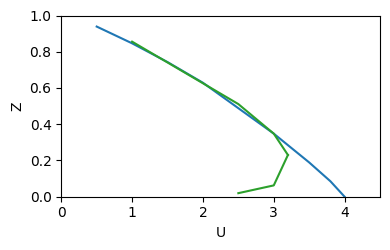

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,2.6))

plt.plot([0.5, 1.0, 1.5, 2.0, 3.0, 3.5, 3.8, 4.0], torch.tensor([0.969, 0.92, 0.862, 0.793, 0.59, 0.435, 0.292, 0.001])**2)
plt.plot([1.0, 2.5, 3.0, 3.2], torch.tensor([0.925, 0.715, 0.59, 0.48])**2, c="tab:green")
plt.plot([2.5, 3.0, 3.2], torch.tensor([0.14, 0.25, 0.48])**2, c="tab:green")

plt.ylabel("Z")
plt.xlabel("U")
plt.ylim(0, 1)
plt.xlim(0, 4.5)
plt.tight_layout()
plt.show()

In [24]:
import torch
import torch.linalg as LA

mat = torch.randn(5,5)
mat = mat + mat.T

dt = 0.001

A = LA.matrix_exp(-dt * mat)

A_ = torch.eye(5) - dt * mat

vec = torch.randn(5)

In [25]:
A @ vec - A_ @ vec

tensor([ 2.1979e-06, -1.2159e-05, -8.1509e-06,  5.3644e-06,  2.2799e-06])

In [9]:
def generate_product_basis_indices(norb_A, norb_B, nocc_total):
    state_labels = [0, 1, 2, 3]
    state_electrons = {0: 0, 1: 1, 2: 1, 3: 2}

    def generate_basis_indices_and_occupations(norb, nocc_max):
        basis_indices_and_occupations = []
        index = 0
        stack = []
        # Each item in stack: (orbital_index, current_electrons)
        stack.append((0, 0))  # Start with the first orbital, zero electrons

        while stack:
            orbital_index, current_electrons = stack.pop()
            if orbital_index == norb:
                # We have a complete configuration
                basis_indices_and_occupations.append((index, current_electrons))
                index += 1
                continue
            for state in state_labels:
                electrons = state_electrons[state]
                new_total = current_electrons + electrons
                if new_total > nocc_max:
                    continue  # Prune branches exceeding maximum electron count
                # Early pruning based on possible electrons remaining
                remaining_orbitals = norb - (orbital_index + 1)
                min_possible_electrons = new_total + remaining_orbitals * min(state_electrons.values())
                max_possible_electrons = new_total + remaining_orbitals * max(state_electrons.values())
                if min_possible_electrons > nocc_max or max_possible_electrons < 0:
                    continue  # Prune branches that can't sum to valid electron counts
                stack.append((orbital_index + 1, new_total))
        return basis_indices_and_occupations

    def build_occ_to_indices_map(basis_indices_and_occupations):
        occ_to_indices = {}
        for index, nocc in basis_indices_and_occupations:
            occ_to_indices.setdefault(nocc, []).append(index)
        return occ_to_indices

    # Generate basis indices and occupation numbers for subsystems A and B
    # For A and B, nocc_max is the maximum possible occupation number (limited by nocc_total or norb * 2)
    nocc_max_A = min(nocc_total, norb_A * 2)
    nocc_max_B = min(nocc_total, norb_B * 2)

    basis_A = generate_basis_indices_and_occupations(norb_A, nocc_max_A)
    basis_B = generate_basis_indices_and_occupations(norb_B, nocc_max_B)

    # Build occupation number to indices mapping
    occ_to_indices_A = build_occ_to_indices_map(basis_A)
    occ_to_indices_B = build_occ_to_indices_map(basis_B)

    # Now, generate the pairs of indices (i, j) where the total occupation number is nocc_total
    indices_pairs = []
    for nocc_A_sub in occ_to_indices_A:
        nocc_B_sub = nocc_total - nocc_A_sub
        if nocc_B_sub in occ_to_indices_B:
            indices_A = occ_to_indices_A[nocc_A_sub]
            indices_B = occ_to_indices_B[nocc_B_sub]
            # Generate all combinations of indices
            for i in indices_A:
                for j in indices_B:
                    indices_pairs.append((i, j))
    return indices_pairs


In [16]:
generate_product_basis_indices(3,9,12).__len__()

2704156

In [7]:
def generate_product_basis_indices(norb_A, norb_B, nocc_total):
    from functools import lru_cache
    from itertools import product

    # Precompute state to electron count mapping
    state_to_electrons = {0: 0, 1: 1, 2: 1, 3: 2}
    # Precompute possible per-orbital states for given electron counts
    electron_to_states = {
        0: [0],
        1: [1, 2],
        2: [3]
    }

    # Generate all sequences of per-orbital electron counts that sum to nocc
    @lru_cache(maxsize=None)
    def generate_sequences(norb, nocc):
        if norb == 0:
            return [[]] if nocc == 0 else []
        sequences = []
        for e in (0, 1, 2):
            if nocc - e >= 0:
                for seq in generate_sequences(norb - 1, nocc - e):
                    sequences.append([e] + seq)
        return sequences

    # Generate all configurations for a given sequence of electron counts
    def generate_configurations(seq):
        options_per_orbital = [
            electron_to_states[e] for e in seq
        ]
        return product(*options_per_orbital)

    # Compute basis index from a configuration
    def compute_basis_index(states):
        index = 0
        for state in states:
            index = (index << 2) | state  # Each state is two bits
        return index

    # Generate basis indices mapping for subsystem
    def generate_basis_indices(norb, nocc_max):
        basis_indices = {}
        for nocc in range(nocc_max + 1):
            sequences = generate_sequences(norb, nocc)
            indices = []
            for seq in sequences:
                for states in generate_configurations(seq):
                    index = compute_basis_index(states)
                    indices.append(index)
            basis_indices[nocc] = indices
        return basis_indices

    # Determine maximum possible occupations
    nocc_max_A = min(nocc_total, norb_A * 2)
    nocc_max_B = min(nocc_total, norb_B * 2)

    # Generate basis indices for A and B
    basis_indices_A = generate_basis_indices(norb_A, nocc_max_A)
    basis_indices_B = generate_basis_indices(norb_B, nocc_max_B)

    # Generate pairs of indices where total occupation equals nocc_total
    indices_pairs = []
    for nocc_A, indices_A in basis_indices_A.items():
        nocc_B = nocc_total - nocc_A
        if nocc_B in basis_indices_B:
            indices_B = basis_indices_B[nocc_B]
            indices_pairs.extend(product(indices_A, indices_B))

    return indices_pairs


In [14]:
generate_product_basis_indices(3,9,12).__len__()

2704156

In [1]:
from gGA.operator import Hubbard, Slater_Kanamori
from gGA.nn.ansatz import gGASingleOrb
import numpy as np
import torch

/root/Hubbard/gGA/utils/kronsum.py:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  input_indices_expanded = input_indices.expand(other_indices.shape[1], *input_indices.shape).T * torch.tensor(other.shape).reshape(1,-1,1)


In [ ]:


N = 1
B = 1
model_s = Slater_Kanamori(
    nsites=N*(B+1),
    U=2.0,
    Up=2.0,
    J=0.5,
    Jp=0.5,
    t=np.eye(4),
    n_noninteracting=N*B
)

NameError: name 'Slater_Kanamori' is not defined

In [2]:
sorb = gGASingleOrb(
    norb=2,
    naux=3,
    Hint_params={"U": 2.0, "Up": 2.0, "J": 0.5, "Jp": 0.5, "t": torch.eye(4)},
    device="cpu"
)
R, RDM = sorb.solve_Hemb("ED")

In [3]:
sorb.LAM_C

tensor([[-0.5558,  0.2053, -1.5353, -0.9419,  0.2364,  1.3598,  0.2408, -1.2499,
          0.2772, -0.1549, -1.4270,  0.4856],
        [ 0.2053,  1.3264,  0.4301,  0.2271, -1.3713, -0.6276,  0.1484, -2.1750,
          1.0662,  0.8075, -0.7578, -1.1137],
        [-1.5353,  0.4301, -2.2450, -0.5702,  0.2643, -0.0451,  0.3031, -1.2172,
          0.3024,  0.4578, -1.7396,  0.7454],
        [-0.9419,  0.2271, -0.5702,  0.4856, -1.1173,  0.6760, -0.0511,  0.0654,
         -0.5389,  0.2676,  0.3805,  0.7325],
        [ 0.2364, -1.3713,  0.2643, -1.1173, -0.3300, -1.1755,  0.5329, -1.0148,
         -2.6262, -0.0551, -0.0965, -2.0393],
        [ 1.3598, -0.6276, -0.0451,  0.6760, -1.1755,  0.2284,  0.3131,  0.8606,
         -1.1195, -0.4863,  0.7788,  0.1444],
        [ 0.2408,  0.1484,  0.3031, -0.0511,  0.5329,  0.3131,  1.5470, -0.0918,
          0.1124, -0.9978, -0.7983,  0.0741],
        [-1.2499, -2.1750, -1.2172,  0.0654, -1.0148,  0.8606, -0.0918, -0.6976,
         -0.5761, -1.3354,  0.

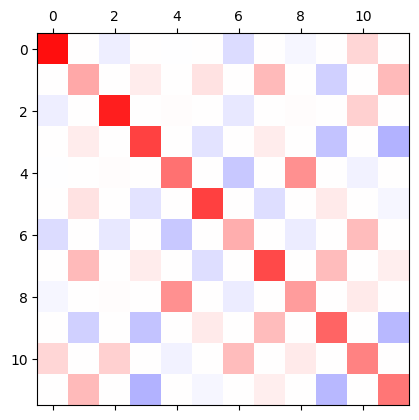

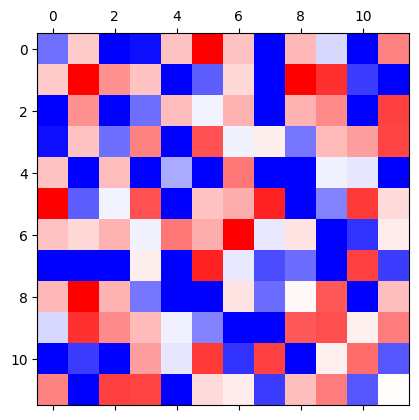

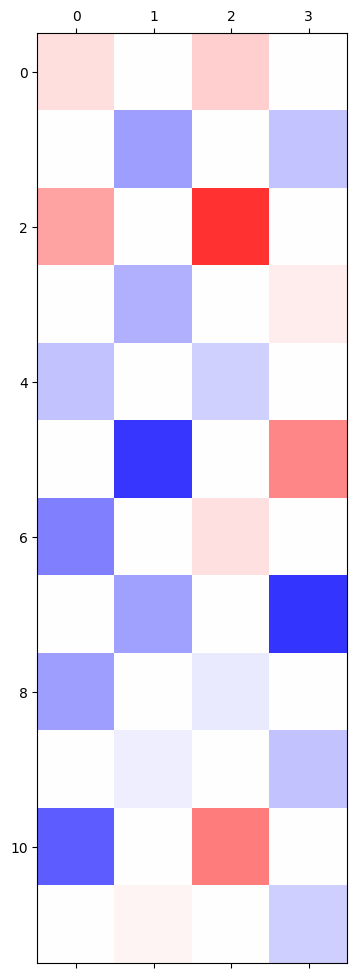

In [4]:
import matplotlib.pyplot as plt

plt.matshow(RDM, cmap="bwr", vmin=-1, vmax=1)
plt.show()

plt.matshow(sorb.LAM_C, cmap="bwr", vmin=-1, vmax=1)
plt.show()

plt.matshow(R, cmap="bwr", vmin=-1, vmax=1)
plt.show()

In [6]:
model_s.get_quspin_op(2, [(1,1)]).expt_value(np.random.randn(4))

NameError: name 'model_s' is not defined

In [1]:
from gGA.data import OrbitalMapper

In [21]:
idp = OrbitalMapper(basis={"Si":[2,4,5], "C": [3,5]}, spin_deg=True)

In [22]:
idp.flistnorbs, idp.full_basis, idp.atom_norb

([2, 3, 4, 5], ['1e', '1p', '1q', '1d'], tensor([ 8, 11]))